In [2]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

def Connectivity(counts):
    counts = np.array(counts)
    s = counts.sum()
    return (s - counts.size) / (s - 1)


class Property(object):
    def __init__(self, label, func, dtype=np.float64):
        self.label = label
        self.func = func
        self.stats = np.empty(0, dtype=dtype)
    
    def AddCounts(self, counts: np.ndarray):
        self.stats = np.append(self.stats, self.func(counts))
        
    def __repr__(self):
        return self.label + ": " + str(np.round(self.stats, 3))

    
@dataclass
class ClusterProperties:
    maximum: Property 
    minimum: Property
    mean: Property
    median: Property
    connectivity: Property
    spread: Property
    
    def AddCounts(self, counts: np.ndarray):
        for field in fields(self):
            attr = getattr(self, field.name)
            attr.AddCounts(counts)
            
    def __repr__(self):
        outstr = "Cluster Properties:\n"
        for field in fields(self):
            outstr += "  " + str(getattr(self, field.name)) + "\n"
        return outstr
    
    
def CreateClusterProperties():
    maximum = Property("Max", np.max, dtype=np.int32)
    minimum = Property("Min", np.min, dtype=np.int32)
    mean = Property("Mean", np.mean)
    median = Property("Median", np.median, dtype=np.int32)
    std = Property("Stddev", np.std)
    spread = Property("Spread", lambda x: np.max(x) - np.min(x), dtype=np.int32)
    connectivity = Property("Connectivity", Connectivity)
    return ClusterProperties(maximum, minimum, mean, median, connectivity, spread)


# Test
properties = CreateClusterProperties()
properties.AddCounts(np.random.randint(10, size=10))
properties.AddCounts(np.random.randint(10, size=10))
print("Test\n-----")
print(properties)

Test
-----
Cluster Properties:
  Max: [8 6]
  Min: [0 1]
  Mean: [5.4 3.6]
  Median: [6.  4.5]
  Connectivity: [0.83  0.743]
  Spread: [8 5]



In [3]:
file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
file = "../data/avantgardeGoal/100k/data_improved_avantgarde-uniform_affinity-uniform_goal-uniform_100.csv"
file = "../data/distributions/agent_data_1000steps_a-normal-10-04.csv"

columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

In [4]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-02.csv"
#file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
#file = "../data/simplified/agent_data_uniform.csv"
data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"])

In [5]:
np.unique(data.seed)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200], dtype=int64)

In [6]:
LAST_STEP = 1000

sample = data.query("seed == 100")
grid = Grid(Avantgarde(sample, LAST_STEP))

In [7]:
data

,step,id,affinity,avantgarde,affinityGoal,seed
0,0,1,0.660911,0.268373,0.190313,100
1,0,2,0.645691,0.357697,0.967600,100
2,0,3,0.972755,0.479214,0.526845,100
3,0,4,0.523990,0.727542,0.172707,100
4,0,5,0.199381,0.577390,0.893169,100
...,...,...,...,...,...,...
2019995,1000,9996,0.461939,0.016985,0.770322,200
2019996,1000,9997,0.485050,0.767882,0.183342,200
2019997,1000,9998,0.499483,0.087925,0.791582,200
2019998,1000,9999,0.508080,0.455917,0.849198,200


In [8]:
beta_dist_path = "../data/distributions/beta/"

def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

@dataclass
class BetaPdf:
    # definition see WIKI
    mean: float
    alpha: float
    beta: float

def GetBetaPdfFromFileName(fname):
    a = float(find_between(fname, "a-", "_"))
    b = float(find_between(fname, "b-", "_"))
    m = float(find_between(fname, "m-", ".csv"))
    return BetaPdf(m, a, b)
        
beta_files = []
for file in os.listdir(beta_dist_path):
    betaPdf = GetBetaPdfFromFileName(file)
    if "agent_data" in file:
        beta_files.append((file, betaPdf))

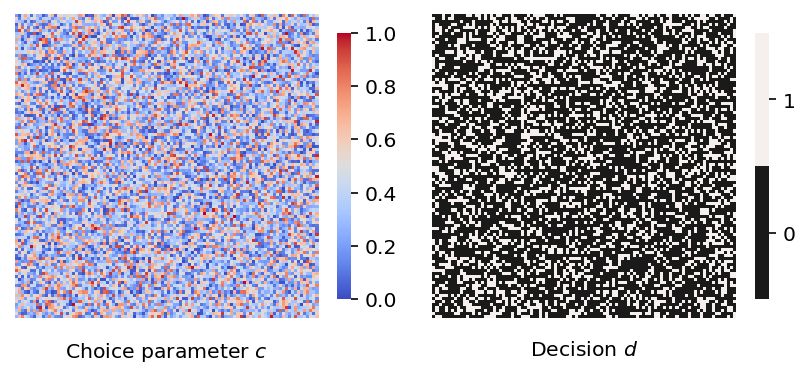

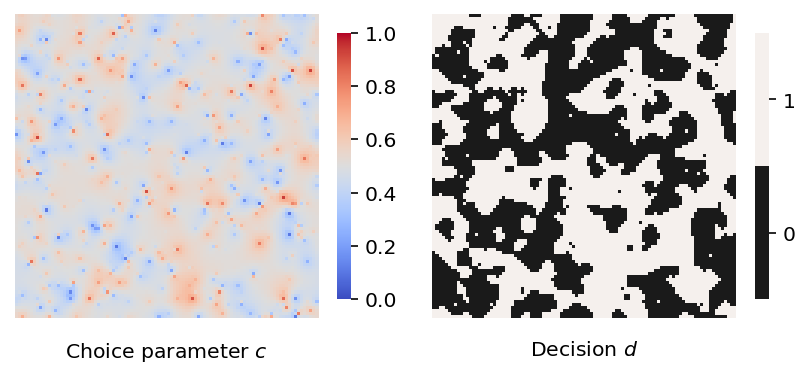

In [9]:
file, dist = beta_files[2]

sample = LoadSimulation(beta_dist_path + file, columns=columns).query("seed == 100")
ShowState(Grid(Avantgarde(sample, 0)))
ShowState(Grid(Choice(sample, 100)))

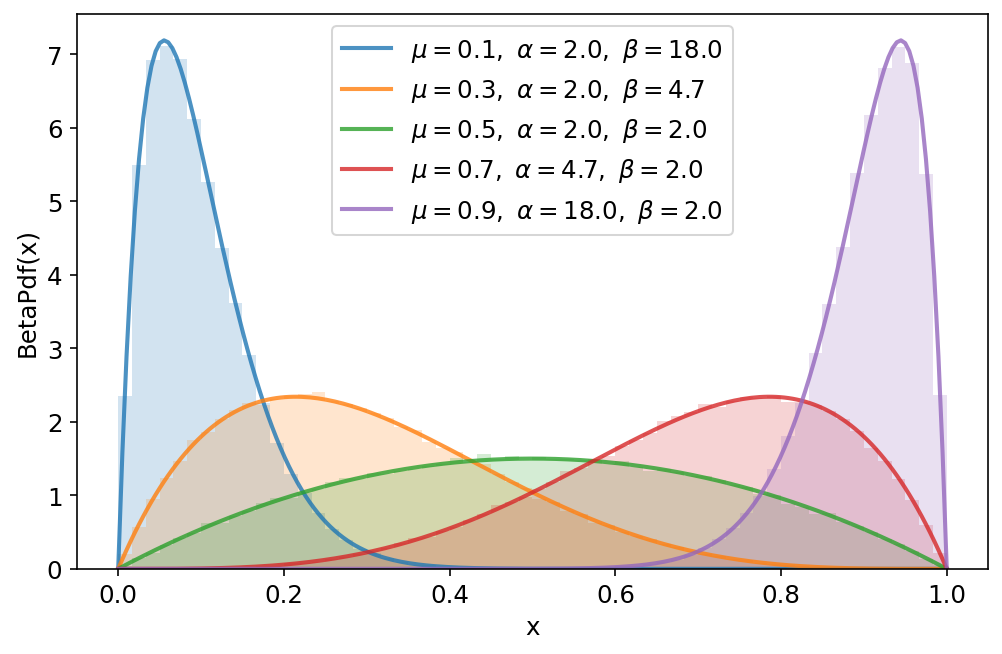

In [10]:
from scipy.stats import beta

plt.rcParams.update({"font.size": 12, "figure.dpi": 147})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

beta_files_filtered = [*(filter(lambda x: \
                                (x[1].alpha == 2.) or \
                                (x[1].beta == 2.), beta_files))]
beta_files_filtered.sort(key = lambda x: x[1].mean)

plt.figure(figsize=(8, 5))

for (file, dist), color in zip(beta_files_filtered[1::4], colors):
    sample = LoadSimulation(beta_dist_path + file, columns=columns)
    nbins = 60
    bins = np.linspace(0.0, 1.0, nbins+1)

    counts = []
    for seed in sample.get("seed").unique()[:10]:
        selection = sample.query("seed == @seed")
        avantgarde_ = selection.get("avantgarde")
        selection_counts, _ = np.histogram(avantgarde_, bins) 
        counts.append(selection_counts)
    counts = np.array(counts)

    x = np.linspace(0.0, 1.0, 200)
    plt.plot(x, beta.pdf(x, dist.alpha, dist.beta), 
             lw=2, alpha=0.8, color=color, 
             label=fr'$\mu={dist.mean:.1f},\ \alpha={dist.alpha:.1f},\ \beta={dist.beta:.1f}$')
             #label=f'Beta({dist.alpha:.2f},{dist.beta:.2f}), m={dist.mean:.2f}')
    
    density = counts / (counts.sum(axis=1)[:, None] * np.diff(bins))
    plt.stairs(density.mean(axis=0), bins, 
               fill=True, alpha=0.2, color=color)
    
    
plt.ylabel("BetaPdf(x)")
plt.xlabel("x")
plt.legend()
plt.show()

In [11]:
@dataclass
class ClusterAnalysis:
    distribution: object
    positive: ClusterProperties
    negative: ClusterProperties
        
    def AddCounts(self, counts: dict):
        self.positive.AddCounts(counts[1])
        self.negative.AddCounts(counts[2])
        return self
        
    def __repr__(self):
        s = "Cluster Analysis for "
        s += f"Distribution = {self.distribution}\n"
        s += "-----" * 6 + "\n"
        s += "Positive " + str(self.positive)
        s += "Negative " + str(self.negative)
        return s
    
    @classmethod
    def GetInstance(cls, distribution: object):
        return ClusterAnalysis(distribution,
            CreateClusterProperties(), CreateClusterProperties())
    

# Test
_results = ClusterAnalysis(BetaPdf(1.0, 1.0, 1.0),
    CreateClusterProperties(), CreateClusterProperties())

# print(_results)

In [12]:
@dataclass
class NormalPdf:
    mean: float
    sigma: float

In [13]:
# Test workflow for sample data
file = "../data/distributions/agent_data_1000steps_a-normal-10-04.csv"
_data = LoadSimulation(file, columns=columns).query("seed == 100")

_clusters = np.digitize(Grid(Choice(_data, 0)), bins=BINARY_CLUSTER_BINS)
_counts, _skipped = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True)

_ca = ClusterAnalysis.GetInstance(distribution=NormalPdf(1.0, 0.4))
_ca.AddCounts(_counts)\
    .AddCounts(_counts)
print(_ca)

Cluster Analysis for Distribution = NormalPdf(mean=1.0, sigma=0.4)
------------------------------
Positive Cluster Properties:
  Max: [42 42]
  Min: [1 1]
  Mean: [1.501 1.501]
  Median: [1. 1.]
  Connectivity: [0.334 0.334]
  Spread: [41 41]
Negative Cluster Properties:
  Max: [29 29]
  Min: [1 1]
  Mean: [1.483 1.483]
  Median: [1. 1.]
  Connectivity: [0.326 0.326]
  Spread: [28 28]



In [14]:
def AddClusterAnalysis(results, distribution, file, final_step=1000, 
                       Exists=lambda x, arr: x in arr): # results: list[ClusterAnalysis]
    if Exists(distribution, [ca.distribution for ca in results]):
        print("Distribution %s already existent." % distribution)
        return
    
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    _data = LoadSimulation(file, columns=columns)
    
    keys = np.random.choice(_data.get("seed").unique(), size=15)

    # init cluster props
    _analysis = ClusterAnalysis.GetInstance(distribution)

    for j, key in enumerate(keys):
        _sample = _data.query("seed == @key")
        _grid_data = Grid(Choice(_sample, final_step))
        _clusters = np.digitize(_grid_data, bins=BINARY_CLUSTER_BINS) # get clusters
        _counts, _ = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True) # CountSizesStrong
        _analysis.AddCounts(_counts) # save data
    results.append(_analysis)

In [21]:
def AddDistributionConstantAvantgarde(results, distribution, path, final_step=800):
    if distribution.value in [ca.distribution.value for ca in results \
                              if type(ca.distribution) == ConstantPdf]:
        print("Distribution %s already existent." % distribution)
        return

    keys = np.array([*range(1, 24)])

    # init cluster props
    _analysis = ClusterAnalysis.GetInstance(distribution)

    for j, key in enumerate(np.random.choice(keys, size=15)):
        file = f"{path}agent_data_800steps_{key:d}.csv"
        _data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal"])
        _sample = _data.query("avantgarde == @distribution.value")
        _grid_data = Grid(Choice(_sample, final_step))
        _clusters = np.digitize(_grid_data, bins=BINARY_CLUSTER_BINS)
        _counts, _ = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True)
        _analysis.AddCounts(_counts)
    results.append(_analysis)

In [16]:
path = "../data/distributions/"

def AddDistFile(files, file, dist):
    files.append((path + file, dist))

In [17]:
# Initialize result files
resultsBlocks = []

In [18]:
ExistsBeta = lambda x, arr: (x.mean, x.alpha, x.beta) in [(a.mean, a.alpha, a.beta) \
                                                          for a in arr if type(a) == BetaPdf]

for file, dist in beta_files[:]:
    print(f"Build cluster analysis for distribution {dist}")
    path = os.path.join(beta_dist_path, file)
    AddClusterAnalysis(resultsBlocks, dist, path, final_step=100, Exists=ExistsBeta)

Build cluster analysis for distribution BetaPdf(mean=0.5, alpha=1.2, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.45, alpha=1.2, beta=1.47)
Build cluster analysis for distribution BetaPdf(mean=0.4, alpha=1.2, beta=1.8)
Build cluster analysis for distribution BetaPdf(mean=0.1, alpha=1.2, beta=10.8)
Build cluster analysis for distribution BetaPdf(mean=0.35, alpha=1.2, beta=2.23)
Build cluster analysis for distribution BetaPdf(mean=0.3, alpha=1.2, beta=2.8)
Build cluster analysis for distribution BetaPdf(mean=0.05, alpha=1.2, beta=22.8)
Build cluster analysis for distribution BetaPdf(mean=0.25, alpha=1.2, beta=3.6)
Build cluster analysis for distribution BetaPdf(mean=0.2, alpha=1.2, beta=4.8)
Build cluster analysis for distribution BetaPdf(mean=0.15, alpha=1.2, beta=6.8)
Build cluster analysis for distribution BetaPdf(mean=0.55, alpha=1.47, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.6, alpha=1.8, beta=1.2)
Build cluster analysis for distribution B

In [22]:
@dataclass
class ConstantPdf:
    value: float # all samples have same value

In [23]:
path = "../data/constant_avantgarde/"
for a in np.arange(0.05, 1.0, 0.05)[:]:
    distribution = ConstantPdf(np.round(a, 2))
    AddDistributionConstantAvantgarde(resultsBlocks, distribution, path)

In [24]:
files = []
AddDistFile(files, "agent_data_1000steps_a-normal-00-02.csv", "Normal(0.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-02.csv", "Normal(0.2, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-02.csv", "Normal(0.4, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-02.csv", "Normal(0.6, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-02.csv", "Normal(0.8, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-02.csv", "Normal(1.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-00-04.csv", "Normal(0.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-04.csv", "Normal(0.2, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-04.csv", "Normal(0.4, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-04.csv", "Normal(0.6, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-04.csv", "Normal(0.8, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-04.csv", "Normal(1.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-02.csv", "Normal(0.5, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-04.csv", "Normal(0.5, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-uniform-025-075.csv", "Uniform(0.25, 0.75)")
AddDistFile(files, "agent_data_1000steps_a-uniform-05-10.csv", "Uniform(0.5, 1.0)")


In [26]:
#for file, distribution in files:
#    AddDistribution(distribution, file, results)

In [27]:
def get_label(key):
    m, sigma = key.strip("Normal(").strip(")").split(", ")
    return fr"$m={float(m):.1f}, \sigma={float(sigma):.1f}$"

get_label("Normal(0.0, 0.4)")

'$m=0.0, \\sigma=0.4$'

AttributeError: 'list' object has no attribute 'keys'

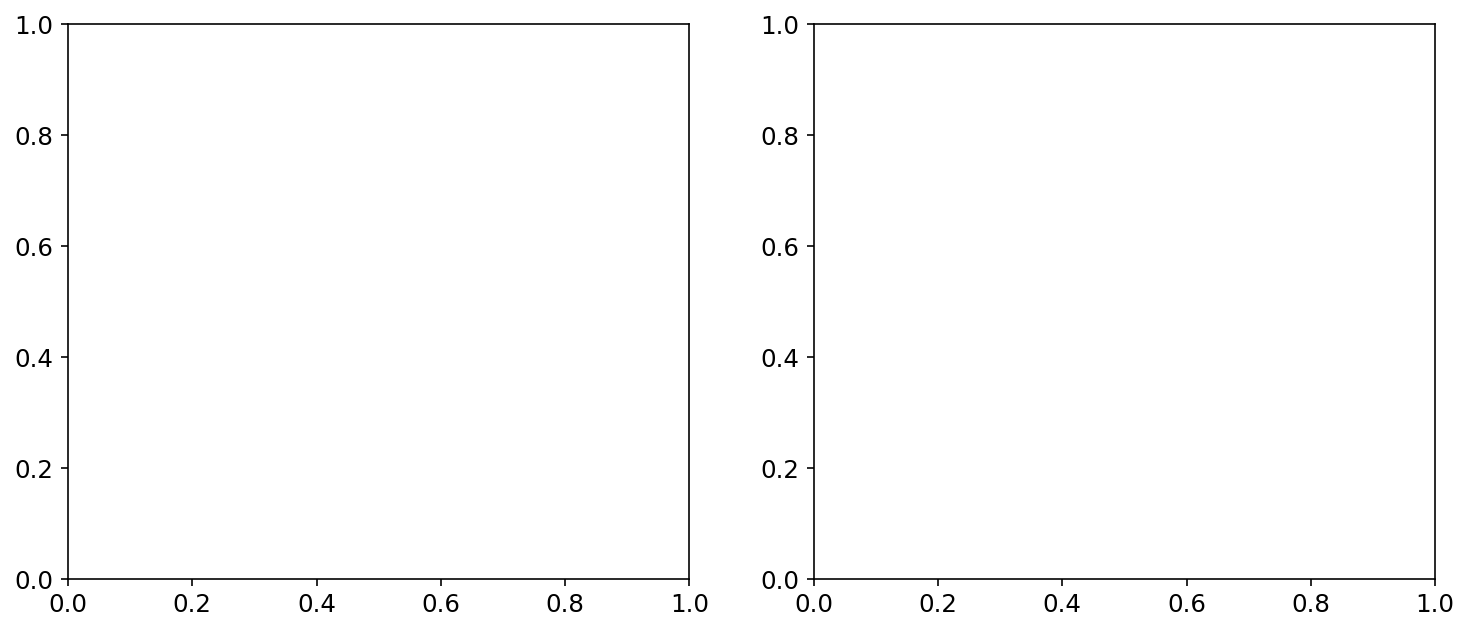

In [28]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

methods = ("connectivity", "maximum")
limits = ([0.6, 1.1], None)
for method, axis, lim in zip(methods, ax.flatten(), limits):
    for key in resultsBlocks.keys():
        if key in ("Uniform(0.25, 0.75)", "Uniform(0.5, 1.0)"):
            continue
        if ".2)" in key: continue
        
        sns.kdeplot(getattr(resultsBlocks[key]["+"], method), label=get_label(key) if method != "connectivity" else None, ax=axis,
                   fill=True)
        #axis.set_xlim(lim)
        #axis.set_ylim([0, 200])
        #axis.legend()
        axis.set_xlabel("Cluster size")
        axis.set_title(method.capitalize())
        
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.005), ncol=4)
plt.gcf().set_dpi(300)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

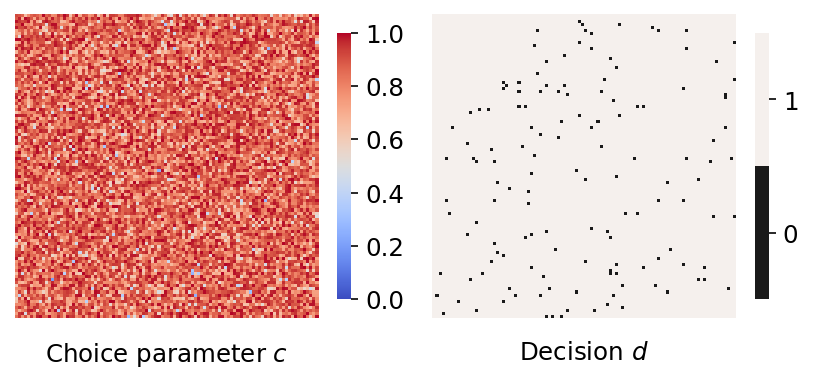

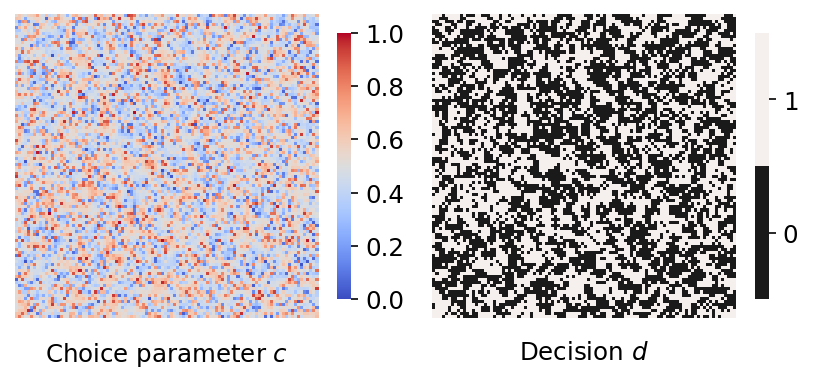

In [29]:
file = "../data/distributions/agent_data_1000steps_a-normal-10-02.csv"
data = LoadSimulation(file, columns=columns)
data = data.query("seed == 151")
ShowState(Grid(Avantgarde(data, 0)))
ShowState(Grid(Choice(data, 1000)))

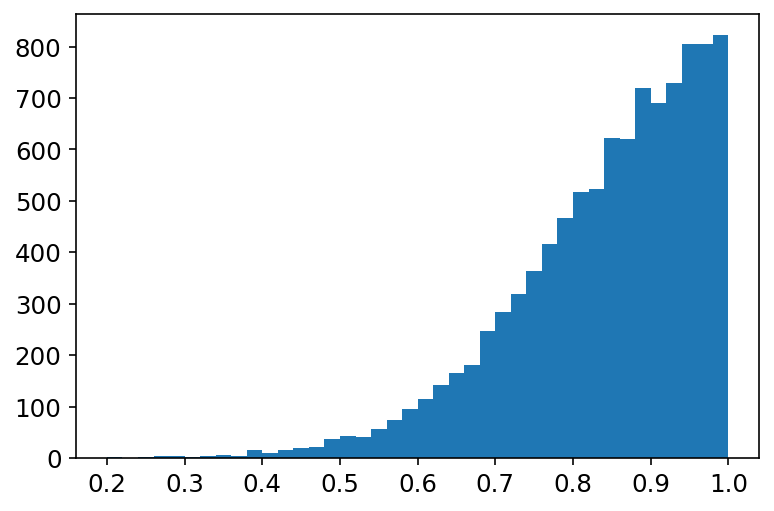

In [30]:
plt.hist(Avantgarde(data, 0), bins=40)
plt.show()

In [31]:
# Cluster size dependence on avantgarde mean / variance

avantgarde_dist = dict()
for _file, dist in files:
    if distribution in avantgarde_dist.keys():
        print("Distribution %s already existent." % distribution)
    elif not os.path.exists(_file):
        print("File %s not found." % _file)
    else:
        _data = LoadSimulation(_file, columns=columns)
        _sample = _data.query("seed == 100")
        _avantgarde = Avantgarde(_sample, 0)
        _true = _avantgarde > 2. / 3
        x = np.sum(_true) / _true.size
        avantgarde_dist[dist] = (np.mean(_avantgarde[_true]) * x, 0)
        
        #(np.mean(_avantgarde), np.var(_avantgarde))
    

File ../data/constant_avantgarde/agent_data_1000steps_a-normal-00-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-02-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-04-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-06-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-08-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-10-02.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-00-04.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-02-04.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-04-04.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-06-04.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-08-04.csv not found.
File ../data/constant_avantgarde/agent_data_1000steps_a-normal-10-04.csv not

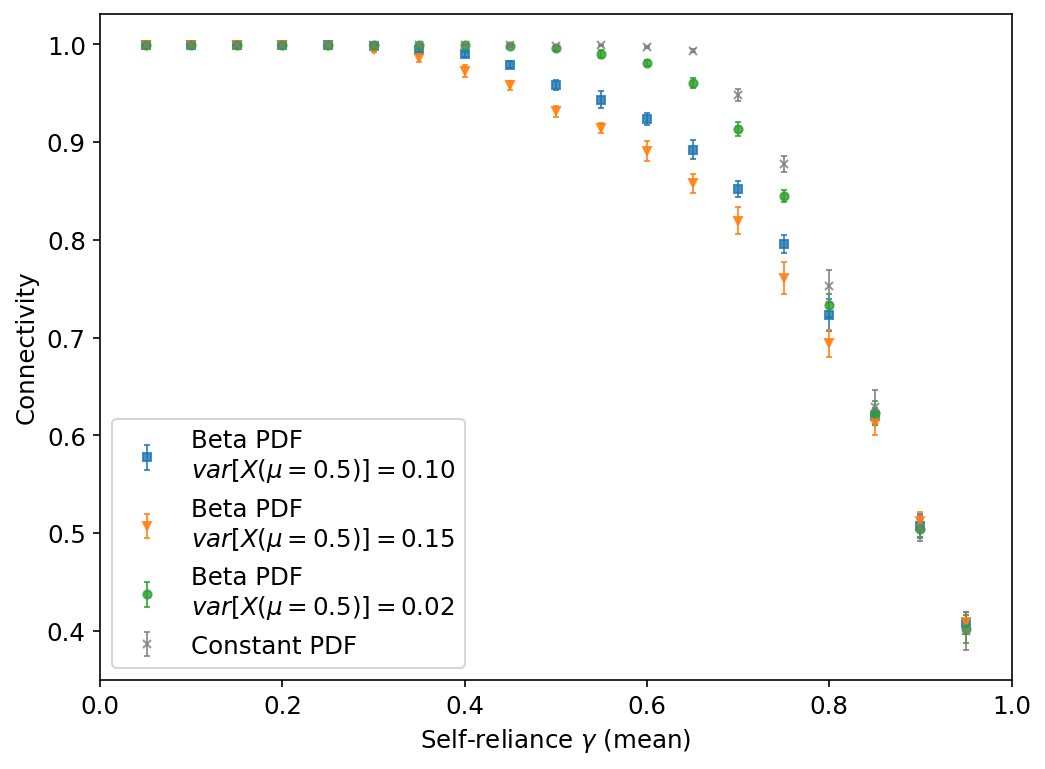

In [32]:
# Plot connectivity
plt.figure(figsize=(8, 6))

plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})

distributions = [ca.distribution for ca in resultsBlocks]
beta_results = [ca for ca in resultsBlocks if type(ca.distribution) == BetaPdf]
const_results = [ca for ca in resultsBlocks if type(ca.distribution) == ConstantPdf]
for value, color, marker in zip((2., 1.2, 10., 0.0, ), \
                                ("tab:blue", "tab:orange", "tab:green", "tab:grey"), \
                                ("s", "v", "o", "x", )):
    
    if value == 0.0:
        xbeta = [ca.distribution.value for ca in const_results]
        results_filtered = const_results
        label = f"Constant PDF"
    else:
        results_filtered = list(filter(lambda x: x.distribution.alpha == value or \
                                       x.distribution.beta == value, beta_results))

        xbeta = [ca.distribution.mean for ca in results_filtered]
        
        variance_at05 = 1./(2 * (2 * value + 1))
        label = f"Beta PDF\n" + fr"$var[X(\mu=0.5)]={variance_at05:.2f}$"
    
    
    ybeta = [ca.positive.connectivity.stats.mean() for ca in results_filtered]
    yerr_beta = [ca.positive.connectivity.stats.std() for ca in results_filtered]
    
    plt.errorbar(xbeta, ybeta, yerr=yerr_beta,
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5, c=color, alpha=0.8,
                 label=label)

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.xlabel(r"Self-reliance $\gamma}$ (mean)")
plt.ylabel("Connectivity")

plt.show()

In [33]:
# plot Connectivity
x04, y04, err04 = [], [], []
x02, y02, err02 = [], [], []
xu, yu, erru = [], [], []
xc, yc, errc = [], [], []
for _dist, _cluster in resultsBlocks.items():
    if "Normal" in _dist:
        if "0.4)" in _dist:
            x04.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y04.append(_cluster["+"].connectivity.mean())
            err04.append(_cluster["+"].connectivity.std())
        elif "0.2)" in _dist:
            x02.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y02.append(_cluster["+"].connectivity.mean())
            err02.append(_cluster["+"].connectivity.std())
    elif "Constant" in _dist:
        print(_dist)
        xc.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yc.append(_cluster["+"].connectivity.mean())
        errc.append(_cluster["+"].connectivity.std())
    else:
        print(_dist)
        xu.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yu.append(_cluster["+"].connectivity.mean())
        erru.append(_cluster["+"].connectivity.std())

plt.figure(figsize=(6, 4))

plt.errorbar(x02, y02, yerr=err02,
             linestyle="", marker="o", ms=4, elinewidth=1., capsize=1.5, color="tab:blue",
             label="Var[a] = 0.2")
plt.errorbar(x04, y04, yerr=err04,
             linestyle="", marker="^", ms=4, elinewidth=1., capsize=1.5, color="tab:orange",
             label="Var[a] = 0.4")
plt.errorbar(xc, yc, yerr=errc,
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5, color="tab:green",
             label="Var[a] = 0.0")
# plt.errorbar(xu, yu, yerr=erru,
#              linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:red",
#              label="Uniform")

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Avantgarde Mean > 2/3")
plt.ylabel("Connectivity")

plt.show()

AttributeError: 'list' object has no attribute 'items'

In [34]:
results_constant_detailed = [ca for ca in resultsBlocks if type(ca.distribution) == ConstantPdf]

path = "../data/constant_avantgarde/"
for a in np.arange(0.00, 1.01, 0.03)[:]:
    distribution = ConstantPdf(np.round(a, 2))
    AddDistributionConstantAvantgarde(results_constant_detailed, distribution, path)

Distribution ConstantPdf(value=0.15) already existent.
Distribution ConstantPdf(value=0.3) already existent.
Distribution ConstantPdf(value=0.45) already existent.
Distribution ConstantPdf(value=0.6) already existent.
Distribution ConstantPdf(value=0.75) already existent.
Distribution ConstantPdf(value=0.9) already existent.


In [41]:
stats

NameError: name 'stats' is not defined

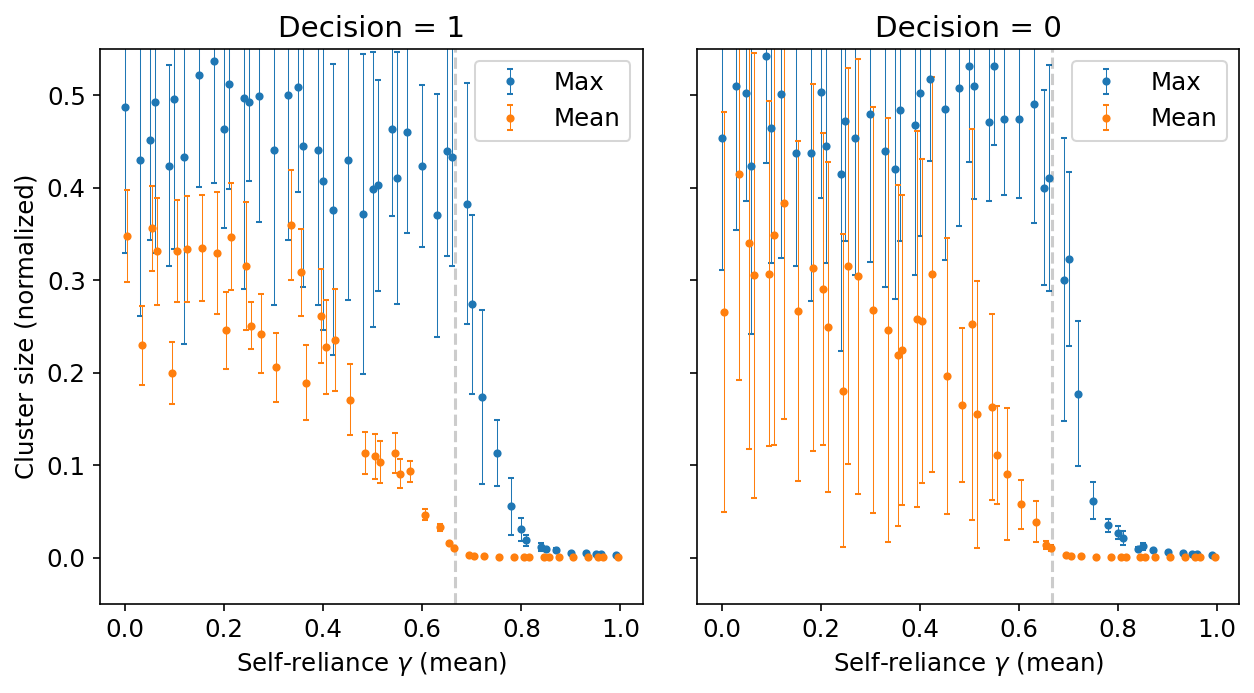

In [39]:
# prepare data
N = 10000
scale = 1.0 / N
_data = results_constant_detailed

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.1)

offset=0.005

axes[0].errorbar(x=[analysis.distribution.value for analysis in _data], 
                 y=[analysis.positive.maximum.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.positive.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:blue", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Max")

axes[0].errorbar(x=[analysis.distribution.value+offset for analysis in _data], 
                 y=[analysis.positive.mean.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.positive.mean.stats.std() * scale / np.sqrt(analysis.positive.mean.stats.size) for analysis in _data], 
                 color="tab:orange", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Mean")

axes[1].errorbar(x=[analysis.distribution.value for analysis in _data], 
                 y=[analysis.negative.maximum.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.negative.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:blue", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Max")

axes[1].errorbar(x=[analysis.distribution.value+offset for analysis in _data], 
                 y=[analysis.negative.mean.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.negative.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:orange", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Mean")

for ax in axes:
    ymin, ymax = -0.1 / 2, 1.1 / 2
    ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.legend()
    ax.set_xlabel(r"Self-reliance $\gamma$ (mean)")

axes[0].set_ylabel("Cluster size (normalized)")
axes[0].title.set_text("Decision = 1")
axes[1].title.set_text("Decision = 0")

plt.show()

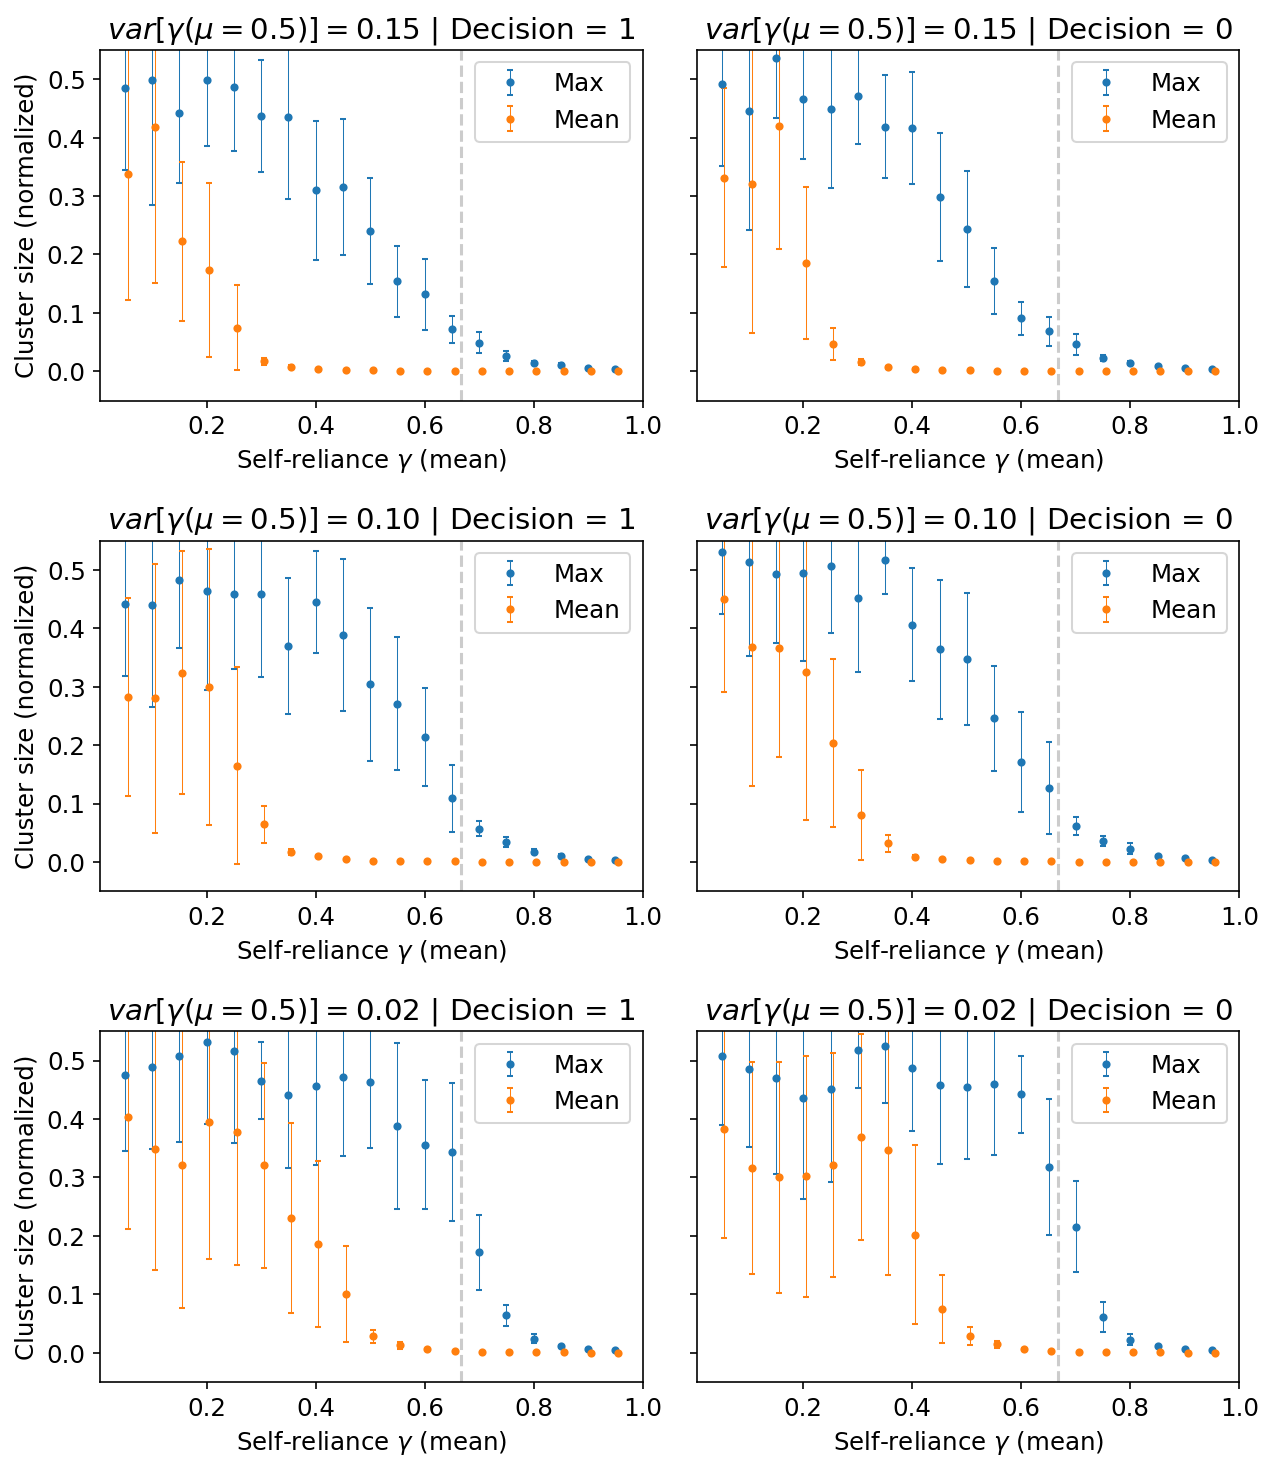

In [37]:
# prepare data
N = 10000
scale = 1.0 / N

def Plot(value, axes):
    _data = list(filter(lambda x: x.distribution.alpha == value or \
                        x.distribution.beta == value, beta_results))

    offset=0.005

    axes[0].errorbar(x=[analysis.distribution.mean for analysis in _data], 
                     y=[analysis.positive.maximum.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.positive.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:blue", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Max")

    axes[0].errorbar(x=[analysis.distribution.mean+offset for analysis in _data], 
                     y=[analysis.positive.mean.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.positive.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:orange", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Mean")

    axes[1].errorbar(x=[analysis.distribution.mean for analysis in _data], 
                     y=[analysis.negative.maximum.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.negative.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:blue", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Max")

    axes[1].errorbar(x=[analysis.distribution.mean+offset for analysis in _data], 
                     y=[analysis.negative.mean.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.negative.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:orange", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Mean")

    for ax in axes:
        ymin, ymax = -0.1 / 2, 1.1 / 2
        ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)
        ax.set_ylim([ymin, ymax])
        ax.legend()
        ax.set_xlabel(r"Self-reliance $\gamma$ (mean)")

    var = 1./(2 * (2 * value + 1))
    axes[0].set_ylabel("Cluster size (normalized)")
    axes[0].title.set_text(fr"$var[\gamma(\mu=0.5)]={var:.2f}$ | Decision = 1")
    axes[1].title.set_text(fr"$var[\gamma(\mu=0.5)]={var:.2f}$ | Decision = 0")

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(10, 12), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
Plot(1.2, ax1)
Plot(2.0, ax2)
Plot(10.0, ax3)
    
plt.show()

In [38]:
aa = np.linspace(0.01, 1.0, 100)
keys = [*range(1, 20)]

# init cluster props
all_props_pos = [ClusterProperties() for a in aa[:]]
all_props_neg = [ClusterProperties() for a in aa[:]]
    
for k in keys:
    columns = ['id','avantgarde', 'affinity', 'affinityGoal', 'step']
    file = f"../data/constant_avantgarde/agent_data_800steps_{k}.csv"
    data = LoadSimulation(file, columns)
    step = 800
    
    for j, a in enumerate(aa[:]):
        a = np.round(a, 2)

        # >--- get cluster sizes
        grid_data = Grid(Choice(data.query("avantgarde == @a"), step))
        labeled_data = np.digitize(grid_data, bins=np.arange(0, 1, 0.5))
        clusters = CountSizes(labeled_data, skip_size=1, corner_neighbours=False)
        # ---<
        
        # save data
        AddClusterProperties(all_props_neg[j], clusters[1])
        AddClusterProperties(all_props_pos[j], clusters[2])


TypeError: ClusterProperties.__init__() missing 6 required positional arguments: 'maximum', 'minimum', 'mean', 'median', 'connectivity', and 'spread'

In [ ]:
# prepare data
N = 10000
scale = 1.0 / N

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

data = (all_props_pos, all_props_neg)

for ax, all_props in zip(axes, data):
    
    x = np.array(aa)
    y = np.array([np.mean(c.median) for c in all_props]) * scale
    std = np.array([np.std(c.median) for c in all_props]) * scale / np.sqrt(10)

    xmax = np.array(aa)
    ymax = np.array([np.mean(c.maximum) for c in all_props]) * scale
    stdmax = np.array([np.mean(c.maximum) for c in all_props]) * scale / np.sqrt(10)
    
    ax.errorbar(x[::], y[::], yerr=err[::1], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:blue",
             label="Median")

    ax.errorbar(xmax[::]+0.005, ymax[::], yerr=errmax[::], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:orange",
             label="Max")
#plt.plot(x, y)

    ymin, ymax = -0.1 / 2, 1.1 / 2
    ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)

    ax.set_ylim([ymin, ymax])

    ax.legend()
    
    ax.set_xlabel(r"Avantgarde $a$")

axes[0].set_ylabel("Normalized Island Size")

axes[0].title.set_text("Positive Decision")
axes[1].title.set_text("Negative Decision")

plt.show()

In [ ]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [ ]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-04.csv"
data = LoadSimulation(file, columns=columns)

islands = np.digitize(Grid(Choice(sample, 1000)), bins=np.arange(0, 1, 0.5))

In [ ]:
X, y = [], []
L = 100
with np.nditer(islands, flags=["multi_index"])as it:
    for x in it:
        X.append([*it.multi_index])
        y.append(x)
    X = np.array(X) * 1./100
    y = np.array(y)

In [ ]:
np.array(y)

In [ ]:
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    
    print(labels)
    plt.figure(figsize=(6, 4))
    for digit in [1]:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=10,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = X
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, compute_full_tree=True, distance_threshold=0.2)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [ ]:
def c1(a1, a2, b1, b2):
    return (a1 * b1 + (1-a1)*a2*b2)/(a1 + a2 - a1*a2)

b1, b2 = 0.5, 1.0
aa = np.linspace(0, 1, 100)
c1 = [c1(a, a, b1, b2) for a in aa]

plt.figure()
plt.plot(aa, c1)
plt.show()

# Clustering algorithms

In [ ]:
from dataclasses import *
import numpy as np

# Class for saving cluster information 
# of a single agent selection
@dataclass
class Clusters:
    n: int
    n_noise: int
    mean_size: float
    std_size: float
    unique_labels: np.ndarray
    counts: np.ndarray
    
    @staticmethod
    def build(labels):
        unique_labels_, counts_ = np.unique(labels, return_counts=True)
        n_ = unique_labels_[unique_labels_ >= 0].size
        n_noise_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
        mean_size_ = counts_[unique_labels_ >= 0].mean()
        std_size_ = counts_[unique_labels_ >= 0].std()

        return Clusters(    
            n_, n_noise_, mean_size_, std_size_, 
            unique_labels_, counts_
        )
    
    def tolist(self): # includes noise
        size_list = self.counts[self.unique_labels >= 0].tolist()
        size_list.extend([1 for _ in range(self.n_noise)])
        return size_list
    
# Class for saving cluster information
# of a single state
@dataclass
class StateClusters:
    positive: Clusters
    negative: Clusters
        
    @staticmethod
    def build(all_labels):
        labels_neg_, labels_pos_ = all_labels
        pos_ = Clusters.build(labels_pos_)
        neg_ = Clusters.build(labels_neg_)
        return StateClusters(pos_, neg_)
    
@dataclass
class StateClusterStats:
    positive: list
    negative: list
    seeds: list
    
    @staticmethod
    def create():
        return StateClusterStats([], [], [])
    
    def add(self, state_clusters, seed):
        self.positive.append(state_clusters.positive)
        self.negative.append(state_clusters.negative)
        self.seeds.append(seed)
        
    def n(self, filtered=""):
        if filtered == "positive":
            return np.array([p_.n for p_ in self.positive])
        elif filtered == "negative":
            return np.array([n_.n for n_ in self.negative])
        else:
            return np.array(
                [c.n for c in self.positive]
                            .extend([n_.n for n_ in self.negative])
            )

In [ ]:
a = np.random.randint(0, 10, size=10)
b = np.unique(a)
b.sort()
b

In [ ]:
from importlib import reload

from AvantgardeModelUtils import *
import BlockNNClustering
reload(BlockNNClustering)
from BlockNNClustering import *

from sklearn_extra.cluster import CommonNNClustering
import numpy as np

# adjust commonNNClustering to used framework
class ExtendedCommonNNClustering:
    
    def __init__(self, eps=1, min_samples=1, metric="chebyshev"):
        self.parent = CommonNNClustering(
            eps=eps, min_samples=min_samples, metric=metric
        )
        
    def fit(self, X_): # X_ is 2d array
        all_labels = []
        values = np.unique(X_)
        values.sort()
        for val in values:    
            xfit = np.argwhere(X_ == val)
            clustering_ = self.parent.fit(xfit)
            # return 2d array of labels
            labels_ = np.ones(X_.shape) * (-2)
            flattened_indices_ = np.ravel_multi_index(xfit.T, X_.shape)
            # Use np.put to fill the array with the values
            np.put(labels_, flattened_indices_, clustering_.labels_)
            all_labels.append(labels_)
            
        return values, all_labels
    
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_cluster_cmap(n): # first entries (-2, -1) are white, red
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, n))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[1, :] = pink
    newcolors[0, :] = np.array([100, 100., 100, 10]) / 256
    newcmp = ListedColormap(newcolors)
    return newcmp

In [ ]:
# check that file has valid affinity states
file = "../data/uniform/data_A_seed100.csv"
attitudes = np.genfromtxt(file, delimiter=' ')


plt.plot(np.diff(attitudes, axis=0).max(axis=1))

In [ ]:
# init clustering models
block_clustering = BlockNNClustering(min_cluster_size=1)
common_clustering0 = ExtendedCommonNNClustering(min_samples=0)
common_clustering1 = ExtendedCommonNNClustering(min_samples=1)
common_clustering2 = ExtendedCommonNNClustering(min_samples=2)
common_clustering3 = ExtendedCommonNNClustering(min_samples=3)

N = 100
n_steps = 30

# init result array
bcc = []
cnn0 = []
cnn1 = []
cnn2 = []
cnn3 = []

for _ in range(n_steps):
    bcc.append(StateClusterStats.create())
    cnn0.append(StateClusterStats.create())
    cnn1.append(StateClusterStats.create())
    cnn2.append(StateClusterStats.create())
    cnn3.append(StateClusterStats.create())

seeds = np.arange(100, 130, 1)
for seed in seeds:
    # load data
    file = f"../data/uniform/data_A_seed{seed}.csv"
    
    # log
    print(f"Working on file: {file}")
    
    attitudes = np.genfromtxt(file, delimiter=' ')

    for i, Aii in enumerate(attitudes[:n_steps]):
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)

        _, all_labels = block_clustering.fit(decisions)
        bcc[i].add(StateClusters.build(all_labels), seed)

        _, all_labels = common_clustering0.fit(decisions)
        cnn0[i].add(StateClusters.build(all_labels), seed)

        _, all_labels = common_clustering1.fit(decisions)
        cnn1[i].add(StateClusters.build(all_labels), seed)

        _, all_labels = common_clustering2.fit(decisions)
        cnn2[i].add(StateClusters.build(all_labels), seed)
        
        _, all_labels = common_clustering3.fit(decisions)
        cnn3[i].add(StateClusters.build(all_labels), seed)
        

In [ ]:
from scipy.optimize import curve_fit
from erroranalysis.rounding import round_din

# define exponential decay function 
# for fitting
def exp_decay(x, a, b, c, tau):
    return a *(1. + b * np.exp(-(x/c)**tau))

# bounds
decay_bounds = ([-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf])
rise_bounds = ([0, -np.inf, 0, 0], [np.inf, 0, np.inf, 1.0])

fig = plt.figure(figsize=(10, 10))
ax_dict = fig.subplot_mosaic([["A"],["B"],["C"]], sharex=True)

ax = [ax_dict["A"], ax_dict["B"], ax_dict["C"]]

figure_props = []
# put (data, label, color, marker)
figure_props.append((block_clusters, "block clustering", "tab:blue", "o"))
figure_props.append((nn_clusters0, "CNN \n$\mathtt{min}\_\mathtt{shared} = 0$", "tab:purple", "*"))
figure_props.append((nn_clusters1, "CNN \n$\mathtt{min}\_\mathtt{shared} = 1$", "tab:orange", "v"))
figure_props.append((nn_clusters2, "CNN \n$\mathtt{min}\_\mathtt{shared} = 2$", "tab:green", "s"))
figure_props.append((nn_clusters3, "CNN \n$\mathtt{min}\_\mathtt{shared} = 3$", "tab:red", "^"))

cluster_data = (block_clusters, nn_clusters0, nn_clusters1, nn_clusters2, nn_clusters3)
labels = ("block clustering", 
          "CNN \n$\mathtt{min}\_\mathtt{shared} = 0$", 
          "CNN \n$\mathtt{min}\_\mathtt{shared} = 1$", 
          "CNN \n$\mathtt{min}\_\mathtt{shared} = 2$", 
          "CNN \n$\mathtt{min}\_\mathtt{shared} = 3$")
colors = ("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple")
markers = ("o", "s", "^", "v", "*")


def get_xyerr(attr_data, n_steps):
    x = np.arange(n_steps)
    y = np.array([np.mean(x_) for x_ in attr_data_[:n_steps]])
    yerr = np.array([np.std(x_) / np.sqrt(x_.size) for x_ in attr_data_[:n_steps]])
    return (x, y, yerr)


def draw_errorbar(x, y, yerr, ax, marker, color, label):
    ax.errorbar(x=x, y=y, yerr=yerr, marker=marker, color=color, label=label,
                   elinewidth=0.5, capsize=1.5, linestyle="", ms="3", alpha=1.)

    
def get_at0(fit_params, cov):
    return (
        round_din(fit_params[0], np.sqrt(cov[0, 0])), 
        round_din(fit_params[2], np.sqrt(cov[2, 2]))
    )


def print_val_err(value, error):
    return f"{value} \pm {error}"


def plot_fitxy(params, n_steps, color, label, ax):
    x = np.linspace(0, n_steps, 100)
    y = exp_decay(x, *params)
    ax.plot(x, y, c=color, alpha=0.4, label=label)


for (data_, label_, color_, marker_) in figure_props:
    # n clusters
    # -----------------
    attr_data_ = [np.array([cl.n for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 30)
    draw_errorbar(x_, y_, yerr_, ax[0], marker_, color_, label_)

    # fit the data using the function
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds if "0" in label_ else decay_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 30, color_, fit_label_, ax[0])
    
    # mean size
    # -----------------
    attr_data_ = [np.array([cl.mean_size for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 30)
    draw_errorbar(x_, y_, yerr_, ax[1], marker_, color_, label_)

    # fit the data using the function
    if "0" in label_:
        x_ = x_[2:]
        y_ = y_[2:]
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 30, color_, fit_label_, ax[1])
    
    # n noise
    # -----------------
    attr_data_ = [np.array([cl.n_noise for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 20)
    draw_errorbar(x_, y_, yerr_, ax[2], marker_, color_, label_)

    # fit the data using the function
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds if "0" in label_ else decay_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 20, color_, fit_label_, ax[2])

    
from itertools import compress
from matplotlib.lines import Line2D

# set plot labels
lines, labels = ax[0].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
# place label
ax[0].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=9)

lines, labels = ax[1].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
# place label
ax[1].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=9)

lines, labels = ax[2].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
# place label
ax[2].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=9)

lines, labels = ax[0].get_legend_handles_labels()
select = [type(x) != Line2D for x in lines]
# add fit function
lines.append(Line2D([0],[0],c="gray"))
labels.append(r"$a \left(1 + b\ \exp\left(- \left(\frac{t}{t_0}\right)^{c}\right)\right)$")
select.append(True)

# place label
fig.legend(compress(lines, select), compress(labels, select), loc="right", fontsize=10, ncol=1)

# set axis labels
#ax[0].set_xlabel(r"Steps $t$")
#ax[1].set_xlabel(r"Steps $t$")
ax[2].set_xlabel(r"Steps $t$")
ax[0].set_ylabel("Number of clusters")
ax[1].set_ylabel("Avg. Cluster size")
ax[2].set_ylabel("Noise count")
ax[1].set_ylim([-10, 250])

plt.subplots_adjust(wspace=0.3, right=0.6)

plt.rcParams.update({"font.size":11, "figure.dpi": 147})
plt.show()

In [ ]:
#############################
# Include random states
#############################
def fit_clusters_on_random_state(my_clustering, N, r):
    # check if only one decision
    if r < 1:
        return [np.ones((N,N))*(-2), np.zeros((N,N))]
    elif r == N*N:
        return [np.zeros((N,N)), np.ones((N,N))*(-2)]

    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    _, labels = my_clustering.fit(grid)
    return labels

N = 100
kk = np.arange(1000, 10000, 250)

# init result array
bcc_rnd = []
cnn0_rnd = []
cnn1_rnd = []
cnn2_rnd = []
cnn3_rnd = []

for _ in kk:
    bcc_rnd.append(StateClusterStats.create())
    cnn0_rnd.append(StateClusterStats.create())
    cnn1_rnd.append(StateClusterStats.create())
    cnn2_rnd.append(StateClusterStats.create())
    cnn3_rnd.append(StateClusterStats.create())

n_loops = 30
for l in range(n_loops):
    for i, k in enumerate(kk):
        all_labels = fit_clusters_on_random_state(block_clustering, N, k)
        bcc_rnd[i].add(StateClusters.build(all_labels), l)
        all_labels = fit_clusters_on_random_state(common_clustering0, N, k)
        cnn0_rnd[i].add(StateClusters.build(all_labels), l)
        all_labels = fit_clusters_on_random_state(common_clustering1, N, k)
        cnn1_rnd[i].add(StateClusters.build(all_labels), l)
        all_labels = fit_clusters_on_random_state(common_clustering2, N, k)
        cnn2_rnd[i].add(StateClusters.build(all_labels), l)
        all_labels = fit_clusters_on_random_state(common_clustering3, N, k)
        cnn3_rnd[i].add(StateClusters.build(all_labels), l)

In [ ]:
cnn0_rnd[0]

In [ ]:
from scipy.optimize import curve_fit
from erroranalysis.rounding import round_din

# define exponential decay function 
# for fitting
def exp_decay(x, a, b, c, tau):
    return a *(1. + b * np.exp(-(x/c)**tau))

# bounds
decay_bounds = ([-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf])
rise_bounds = ([0, -np.inf, 0, 0], [np.inf, 0, np.inf, 1.0])

fig, ax = plt.subplots(3, 2, figsize=(10, 9), sharex="col")

plt.rcParams.update({"font.size": 10, "figure.dpi": 147})

figure_props = []
# put (data, label, color, marker)
figure_props.append((block_clusters, bcc_rnd, "Block clustering", "tab:blue", "x"))
figure_props.append((nn_clusters0, cnn0_rnd, "CNN $\mathtt{min}\_\mathtt{shared} = 0$", "tab:purple", "x"))
figure_props.append((nn_clusters1, cnn1_rnd, "CNN $\mathtt{min}\_\mathtt{shared} = 1$", "tab:orange", "x"))
figure_props.append((nn_clusters2, cnn2_rnd, "CNN $\mathtt{min}\_\mathtt{shared} = 2$", "tab:green", "x"))
figure_props.append((nn_clusters3, cnn3_rnd, "CNN $\mathtt{min}\_\mathtt{shared} = 3$", "tab:red", "x"))

def get_xyerr(attr_data, n_steps):
    x = np.arange(n_steps)
    y = np.array([np.mean(x_) for x_ in attr_data_[:n_steps]])
    yerr = np.array([np.std(x_) / np.sqrt(x_.size) for x_ in attr_data_[:n_steps]])
    return (x, y, yerr)


def draw_errorbar(x, y, yerr, ax, marker, color, label):
    ax.errorbar(x=x, y=y, yerr=yerr, marker=marker, color=color, label=label,
                   elinewidth=0.5, capsize=1.5, linestyle="", ms="3", alpha=1.)

    
def get_at0(fit_params, cov):
    return (
        round_din(fit_params[0], np.sqrt(cov[0, 0])), 
        round_din(fit_params[2], np.sqrt(cov[2, 2]))
    )


def print_val_err(value, error):
    return f"{value} \pm {error}"


def plot_fitxy(params, n_steps, color, label, ax):
    x = np.linspace(0, n_steps, 100)
    y = exp_decay(x, *params)
    ax.plot(x, y, c=color, alpha=0.4, linewidth=0.8, label=label)


for (data_, data_rnd_, label_, color_, marker_) in figure_props:
    # n clusters
    # -----------------
    attr_data_ = [np.array([cl.n for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 20)
    draw_errorbar(x_, y_, yerr_, ax[0,1], marker_, color_, label_)

    # fit the data using the function
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds if "0" in label_ else decay_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 20, color_, fit_label_, ax[0,1])
    
    ## random n clusters
    attr_data_ = [np.array([cl.n for cl in bc.positive]) for bc in data_rnd_]    
    y = np.array([np.mean(x_) for x_ in attr_data_])
    yerr = np.array([np.std(x_)/np.sqrt(x_.size) for x_ in attr_data_])
    draw_errorbar(kk / 10_000, y, yerr, ax[0,0], marker_, color_, label_)
    
    
    # mean size
    # -----------------
    attr_data_ = [np.array([cl.mean_size for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 20)
    draw_errorbar(x_, y_, yerr_, ax[2,1], marker_, color_, label_)

    # fit the data using the function
    if "0" in label_:
        x_ = x_[2:]
        y_ = y_[2:]
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 20, color_, fit_label_, ax[2,1])
    
    ## random size
    attr_data_ = [np.array([cl.mean_size for cl in bc.positive]) for bc in data_rnd_]    
    y = np.array([np.mean(x_) for x_ in attr_data_])
    yerr = np.array([np.std(x_)/np.sqrt(x_.size) for x_ in attr_data_])
    draw_errorbar(kk / 10_000, y, yerr, ax[2,0], marker_, color_, label_)
    
    # n noise
    # -----------------
    attr_data_ = [np.array([cl.n_noise for cl in bc.positive]) for bc in data_]    
    x_, y_, yerr_ = get_xyerr(attr_data_, 20)
    draw_errorbar(x_, y_, yerr_, ax[1,1], marker_, color_, label_)

    # fit the data using the function
    params, cov = curve_fit(exp_decay, x_, y_, maxfev=1200, bounds=rise_bounds if "0" in label_ else decay_bounds)
    (a, aerr), (t0, t0err) = get_at0(params, cov)
    fit_label_ = fr"$a = {print_val_err(a, aerr)}$,  $t_0 = {print_val_err(t0, t0err)}$"
    plot_fitxy(params, 20, color_, fit_label_, ax[1,1])
    
    ## random n clusters
    attr_data_ = [np.array([cl.n_noise for cl in bc.positive]) for bc in data_rnd_]    
    y = np.array([np.mean(x_) for x_ in attr_data_])
    yerr = np.array([np.std(x_)/np.sqrt(x_.size) for x_ in attr_data_])
    draw_errorbar(kk / 10_000, y, yerr, ax[1,0], marker_, color_, label_)

    
from itertools import compress
from matplotlib.lines import Line2D

def add_fit_function_to_labels(lines, labels, select):
    lines.insert(0, Line2D([0],[0],c="gray",linewidth=0.8,alpha=0.8))
    labels.insert(0, r"$f(t) = a \left(1 + b\ \exp\left(- \left(\frac{t}{t_0}\right)^{c}\right)\right)$")
    select.insert(0,True)

# set plot labels
lines, labels = ax[0,1].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
add_fit_function_to_labels(lines, labels, select)
# place label
ax[0,1].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=7)

lines, labels = ax[2,1].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
#add_fit_function_to_labels(lines, labels, select)
# place label
ax[2,1].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=7)

lines, labels = ax[1,1].get_legend_handles_labels()
select = [type(x) == Line2D for x in lines]
#add_fit_function_to_labels(lines, labels, select)
# place label
ax[1,1].legend(compress(lines, select), compress(labels, select), loc="upper right", fontsize=7)

lines, labels = ax[0,0].get_legend_handles_labels()
select = [type(x) != Line2D for x in lines]
# add fit function



# place label
ax[2,0].legend(compress(lines, select), compress(labels, select), loc="best", fontsize=9, ncol=1)

# set axis labels
#ax[0].set_xlabel(r"Steps $t$")
#ax[1].set_xlabel(r"Steps $t$")
ax[2,1].set_xlabel(r"Steps $t$")
ax[0,0].set_ylabel("Number of clusters")
ax[2,0].set_ylabel("Avg. Cluster size")
ax[1,0].set_ylabel("Noise count")
ax[2,1].set_ylim([-10, 250])
ax[2,0].set_xlabel(r"Number of supporters $N_s\ /\ N$")

ax[2,0].set_title("(a) Uniform Distributed States at $t=0$", y=-0.4)
ax[2,1].set_title("(b) Time Evolution of State with $n_s=0.5$", y=-0.4)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()

In [ ]:
counts = [c for i in range(30) for c in block_clusters[230].positive[i].counts]
labels = block_clusters[0].positive[0].unique_labels

n_noise = counts[1]
cluster_sizes = counts[2:]
#cluster_sizes = np.concatenate([cluster_sizes, [1 for _ in range(n_noise)]])
#print(counts)
plt.hist(cluster_sizes, bins=np.logspace(np.log10(4),np.log10(1500), 20), log=True)
plt.gca().set_xscale("log")

In [ ]:
val_err = (1.256, 0.004)

print_val_err(val_err[0], val_err[1])

In [ ]:
attitudes100 = attitudes[5]
N = 100
decisions = np.int32(attitudes100.reshape(N, N) >= 0.5)

values, all_labels = BlockNNClustering(min_cluster_size=1).fit(decisions)
labels_pos, labels_neg = all_labels

pos_clusters = Clusters.build(labels_pos)
neg_clusters = Clusters.build(labels_neg)

print(f"positive clusters: {pos_clusters.n} with mean size {pos_clusters.mean_size:.2f}")
print(f"positive noise count: {pos_clusters.n_noise}")
print(f"negative clusters: {neg_clusters.n} with mean size {neg_clusters.mean_size:.2f}")
print(f"negative noise count: {neg_clusters.n_noise}")

plt.figure(figsize=(4, 4))
plt.imshow(labels_pos, cmap=get_newcmp(np.unique(labels_pos).size))

In [ ]:
# plot different clustered states

def get_cluster_cmap(n): # first entries (-2, -1) are white, red
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, n))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[1, :] = np.array([10, 10, 10, 100]) / 256
    newcolors[0, :] = np.array([100, 100., 100, 10]) / 256
    newcmp = ListedColormap(newcolors)
    return newcmp

# init clustering models
block_clustering = BlockNNClustering(min_cluster_size=1)
common_clustering0 = ExtendedCommonNNClustering(min_samples=0)
common_clustering3 = ExtendedCommonNNClustering(min_samples=3)

N = 100
n_steps = 231

# load data
file = f"../data/uniform/data_A_seed{100}.csv"
attitudes = np.genfromtxt(file, delimiter=' ')

final_step = 230
Aii = attitudes[final_step]
decisions = np.int32(Aii.reshape(N, N) >= 0.5)

w, h = 25, 75
decisions = decisions[w:h, w:h]

_, (pos0, neg0) = common_clustering0.fit(decisions)
_, (pos2, neg2) = common_clustering2.fit(decisions)
_, (posB, negB) = block_clustering.fit(decisions)

all_values = np.concatenate((pos0.flatten(), pos2.flatten(), posB.flatten()), axis=0)
n_values = np.unique(all_values).size
cmap = get_cluster_cmap(n_values)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].imshow(pos0, cmap=get_cluster_cmap(np.unique(pos0).size))
ax[1].imshow(pos2, cmap=get_cluster_cmap(np.unique(pos2).size))
im = ax[2].imshow(posB, cmap=get_cluster_cmap(np.unique(posB).size))

plt.subplots_adjust(wspace=0.5)

ax[0].set_xlabel(r" (a) CNN ($\mathtt{min}\_\mathtt{shared}$ = 0)", fontsize=12, labelpad=14)
ax[1].set_xlabel(r" (b) CNN ($\mathtt{min}\_\mathtt{shared}$ = 2)", fontsize=12, labelpad=14)
ax[2].set_xlabel(r" (c) $2 x 2$-block clustering ", fontsize=12, labelpad=14)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    #axis.set_xticklabels("")
    #axis.set_xticklabels("")

#fig.subplots_adjust(bottom=0.2)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

labels = ["background", "noise", "clusters"]
legend_elements = [Line2D([0], [0], linestyle="", marker='s', markerfacecolor=cmap(0), markeredgecolor="black", markersize=10),
                   Line2D([0], [0], linestyle="", marker='s', markerfacecolor=cmap(1), markeredgecolor="black", markersize=10),
                   Line2D([0], [0], linestyle="", marker='s', markerfacecolor=cmap(4), markeredgecolor="black", markersize=10)]
fig.legend(legend_elements, labels, loc='upper center', ncol=4)

fig.subplots_adjust(wspace=0.1)

In [ ]:
%%timeit
values, all_labels = BlockNNClustering(min_cluster_size=1).fit(decisions)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

def scenario_map(n): # first entries (-2, -1) are white, red
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 0.2, n))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[1, :] = np.array([10, 10, 10, 70]) / 256
    newcolors[0, :] = np.array([100, 100., 100, 10]) / 256
    newcmp = ListedColormap(newcolors)
    return newcmp

arr = [[1,1,0,0], [1,1,1,0], [0, 0, 1, 1], [0, 0, 0.5, 0]]
ax1.imshow(arr, cmap=scenario_map(3))

arr = [[1,1,0,0], [1,1,0.5,0], [0,0,0.5,0.5], [0, 0, 0.5, 0]]
ax2.imshow(arr, cmap=scenario_map(3))

arr = [[0,0.5,0,0], [1,1,1,0.5], [1,1,1,1], [0,1,1, 0]]
ax3.imshow(arr, cmap=scenario_map(3))

arr = [[0,0.5,0,0], [1,1,1,1], [1,1,1,1], [0,1,1, 0]]
ax4.imshow(arr, cmap=scenario_map(3))

for axis in (ax1, ax2, ax3, ax4):
    axis.set_xticks([])
    axis.set_yticks([])
    
fs = 11
lp = 14
ax1.set_title("Scenario I\n" + r"CNN ($\mathtt{min}\_\mathtt{shared}$ = 2)", fontsize=fs)
ax1.set_xlabel("(a)", fontsize=fs, labelpad=lp)
ax2.set_title("Scenario I\n" + r"$2 x 2$-block clustering", fontsize=fs)
ax2.set_xlabel("(b)", fontsize=fs, labelpad=lp)
ax3.set_title("Scenario II\n" + r"CNN ($\mathtt{min}\_\mathtt{shared}$ = 3)", fontsize=fs)
ax3.set_xlabel("(c)", fontsize=fs, labelpad=lp)
ax4.set_title("Scenario II\n" + r"$2 x 2$-block clustering", fontsize=fs)
ax4.set_xlabel("(d)", fontsize=fs, labelpad=lp)
    
plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
_ca = ClusterAnalysis.GetInstance(distribution=None)
_ca.AddCounts(counts)
print(_ca)+

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Generate sample data
np.random.seed(0)
X = np.random.randn(50, 2)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters = dbscan.fit_predict(X)

# Plot the clusters
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()


In [ ]:
# convert state into x, y coordinates
step = 140
choice = Choice(sample_uniform, 1000)

x = np.linspace(1, 100, 100)
xv, yv = np.meshgrid(x, x)
xx = xv.flatten()
yy = yv.flatten()

X = np.stack([xx, yy], axis=1)[choice <= 0.5]
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.axis("equal")

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.01, min_samples=100)
clusters = dbscan.fit_predict(X)

# Plot the clusters
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()